In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import nltk
from nltk.corpus import stopwords
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.losses import Huber
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv("data/updatemergedata.csv")
data.head()

,Learning Path ID,Learning Path,Learning Path Summary,Course ID,Course Name_x,Course Summary,Price,Level,Total Jam Belajar,Rating,Jumlah Enrollment,Jumlah Modul/Tutorial,Judul Modul/Tutorial
0,7,Android Developer,Kurikulum didesain dengan persetujuan dari Tim...,80,Memulai Pemrograman dengan Kotlin,"Pelajari dasar bahasa pemrograman, functional ...",Berbayar,Dasar,50,4.84,67917,132,Latihan Ujian
1,7,Android Developer,Kurikulum didesain dengan persetujuan dari Tim...,80,Memulai Pemrograman dengan Kotlin,"Pelajari dasar bahasa pemrograman, functional ...",Berbayar,Dasar,50,4.84,67917,132,Pengenalan Kotlin
2,7,Android Developer,Kurikulum didesain dengan persetujuan dari Tim...,80,Memulai Pemrograman dengan Kotlin,"Pelajari dasar bahasa pemrograman, functional ...",Berbayar,Dasar,50,4.84,67917,132,Kotlin Sebagai Bahasa Multiparadigm
3,7,Android Developer,Kurikulum didesain dengan persetujuan dari Tim...,80,Memulai Pemrograman dengan Kotlin,"Pelajari dasar bahasa pemrograman, functional ...",Berbayar,Dasar,50,4.84,67917,132,Kotlin Sebagai Bahasa Multiplatform
4,7,Android Developer,Kurikulum didesain dengan persetujuan dari Tim...,80,Memulai Pemrograman dengan Kotlin,"Pelajari dasar bahasa pemrograman, functional ...",Berbayar,Dasar,50,4.84,67917,132,Kotlin untuk Aplikasi Server-side


In [7]:
label_encoder = LabelEncoder()
data['Level'] = label_encoder.fit_transform(data['Level']) 
data['Price'] = data['Price'].map({'Berbayar': 1, 'Gratis': 0})

In [8]:
# 1. Stopwords dan TF-IDF dari teks
indonesian_stopwords = stopwords.words('indonesian')
data['Combined Summary'] = data['Learning Path'] + ' ' + data['Learning Path Summary'] + ' ' + data['Course Name_x'] + ' ' + data['Course Summary']
tfidf = TfidfVectorizer(stop_words=indonesian_stopwords)
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()  # Ubah ke array agar bisa digunakan


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [9]:
# 2. Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix)

In [10]:
# 3. Membuat arsitektur Autoencoder
input_dim = X_scaled.shape[1]
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoded = Dense(128, kernel_regularizer=l2(0.01))(input_layer)
encoded = LeakyReLU(negative_slope=0.01)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, kernel_regularizer=l2(0.01))(encoded)
encoded = LeakyReLU(negative_slope=0.01)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(32, kernel_regularizer=l2(0.01))(encoded)

decoded = Dense(64, kernel_regularizer=l2(0.01))(encoded)
decoded = LeakyReLU(negative_slope=0.01)(decoded)
decoded = Dense(128, kernel_regularizer=l2(0.01))(decoded)
decoded = LeakyReLU(negative_slope=0.01)(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_layer, decoded)

# 4. Compile dan melatih model Autoencoder
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss=Huber())

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

autoencoder.save("autoencoder_model.h5")

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4442 - val_loss: 1.1405
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8031 - val_loss: 0.4336
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3074 - val_loss: 0.2722
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1939 - val_loss: 0.2351
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1659 - val_loss: 0.2260
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 - val_loss: 0.2242
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1581 - val_loss: 0.2233
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1588 - val_loss: 0.2231
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1569 - val_loss: 0.2226
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1579 - val_loss: 0.2228
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1561 - val_loss: 0.2227
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1569 - val_lo

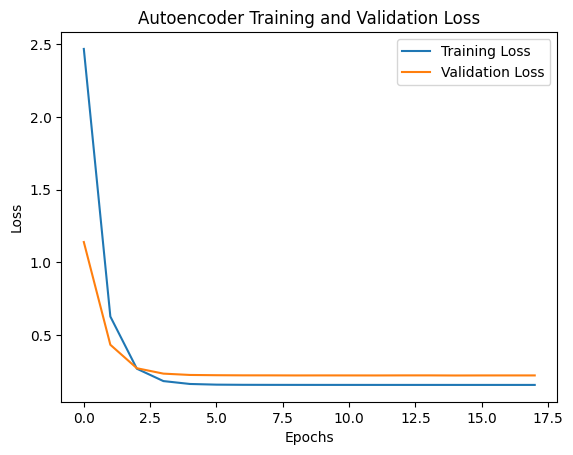

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Top 3 Recommended Learning Paths:
                   Course Name_x
1412  Belajar Dasar Data Science
1413  Belajar Dasar Data Science
1414  Belajar Dasar Data Science


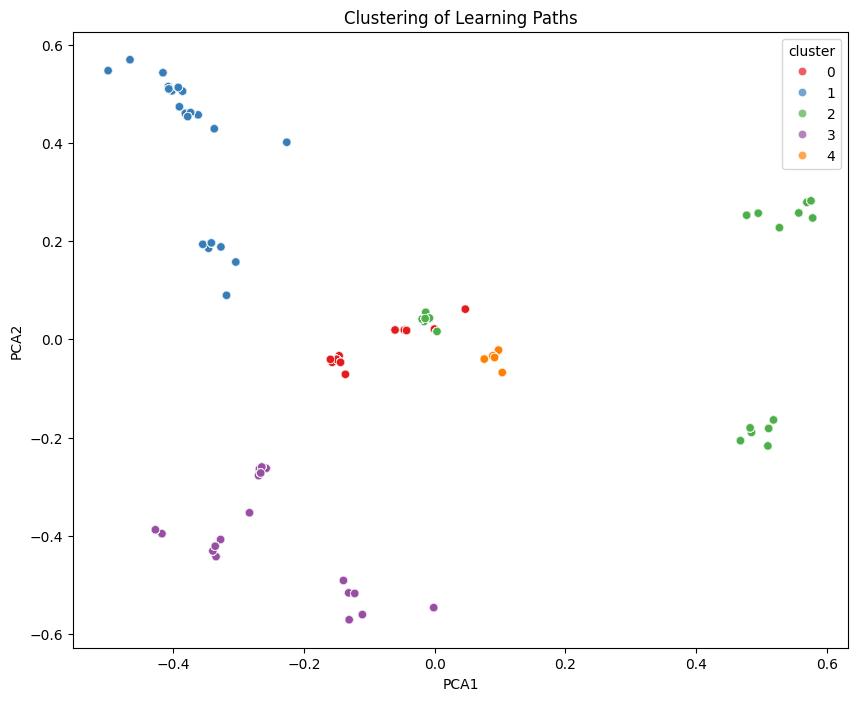

In [74]:
def preprocess_learning_paths(data):
    # Gabungkan fitur menjadi satu kolom
    data['combined_features'] = data.apply(lambda x: f"{x['Learning Path']} {x['Learning Path Summary']} {x['Course Name_x']}", axis=1)
    return data

def vectorize_learning_paths(data):
    # Vectorisasi dengan Tfidf
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(data['combined_features'])

def cluster_learning_paths(data, num_clusters=5):
    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(data)
    return clusters

def visualize_clusters(learning_paths_vectors, clusters):
    # Visualisasi clustering menggunakan PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(learning_paths_vectors.toarray())
    
    # PCA results
    pca_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
    pca_df['cluster'] = clusters
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='Set1', alpha=0.7)
    plt.title('Clustering of Learning Paths')
    plt.show()

# Menyusun rekomendasi
def recommend_learning_paths(data, user_preferences):
    data = preprocess_learning_paths(data)
    learning_paths_vectors = vectorize_learning_paths(data)
    clusters = cluster_learning_paths(learning_paths_vectors)
    data['cluster'] = clusters
    
    # Menghitung kemiripan
    user_vector = " ".join(user_preferences)
    vectorizer = TfidfVectorizer()
    all_vectors = vectorizer.fit_transform(data['combined_features'].tolist() + [user_vector])
    user_vector_tfidf = all_vectors[-1]
    learning_paths_vectors = all_vectors[:-1]
    
    similarity_scores = cosine_similarity(user_vector_tfidf, learning_paths_vectors)
    data['similarity'] = similarity_scores.flatten()
    
    recommendations = data.sort_values(by='similarity', ascending=False).head(3)
    
    return recommendations, learning_paths_vectors, clusters

# Contoh Penggunaan
user_preferences = ["Machine Learning", "Python", "Data Science"]  # Misalnya
recommendations, learning_paths_vectors, clusters = recommend_learning_paths(data, user_preferences)

print("\nTop 3 Recommended Learning Paths:")
print(recommendations[['Course Name_x']])

# Visualisasi kluster
visualize_clusters(learning_paths_vectors, clusters)

In [29]:
from sklearn.cluster import KMeans
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from nltk.corpus import stopwords

# Load preprocessed data and encoder model
data = pd.read_csv("data/updatemergedata.csv")
encoder = load_model("autoencoder_model.h5")
data['Combined Summary'] = data['Learning Path'] + ' ' + data['Learning Path Summary'] + ' ' + data['Course Name_x'] + ' ' + data['Course Summary']

# Create embeddings using the encoder
indonesian_stopwords = stopwords.words('indonesian')
tfidf = TfidfVectorizer(stop_words=stopwords.words('indonesian'))
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix)
X_embeddings = encoder.predict(X_scaled)

# Train KMeans on encoder embeddings
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(X_embeddings)

# Save KMeans model
joblib.dump(kmeans, 'kmeans_model.joblib')


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


['kmeans_model.joblib']

In [ ]:
# 6. Menentukan jumlah cluster optimal dengan metode Elbow
def optimal_kmeans_clusters(data):
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.show()

optimal_kmeans_clusters(encoded_data)

C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


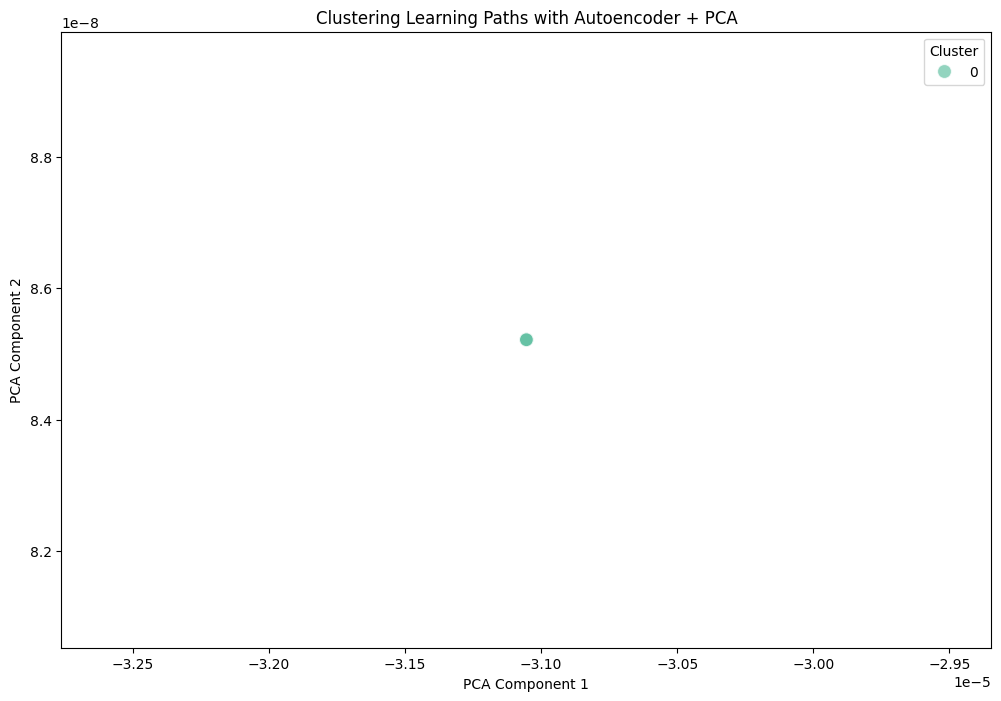

In [63]:
# 7. Clustering menggunakan KMeans
num_clusters = 5  # Sesuaikan dengan hasil dari metode Elbow
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(encoded_data)
data['Cluster'] = clusters

# 8. Visualisasi hasil clustering menggunakan PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_data)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=clusters, palette='Set2', s=100, alpha=0.7)
plt.title('Clustering Learning Paths with Autoencoder + PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

In [64]:
# 9. Menganalisis rekomendasi berbasis cluster terdekat
def recommend_learning_paths(user_vector, cluster_data, num_recommendations=3):
    # Menghitung kemiripan antara vektor user dengan data dalam cluster
    similarity_scores = cosine_similarity(user_vector, cluster_data).flatten()
    
    # Mendapatkan rekomendasi dengan skor kemiripan tertinggi
    top_indices = similarity_scores.argsort()[-num_recommendations:][::-1]
    top_recommendations = data.iloc[top_indices]
    
    return top_recommendations[['ID', 'Nama Path', 'Bahasa Utama', 'Kategori', 'Tingkat']]


In [65]:
# 10. Contoh: Membuat vektor preferensi pengguna dan mendapatkan rekomendasi
user_preferences_vector = vectorizer.transform([get_user_preferences_vector(user_preferences)])
recommendations = recommend_learning_paths(user_preferences_vector, encoded_data)
print("\nTop 3 Recommended Learning Paths:\n", recommendations)

# 11. Evaluasi model Autoencoder (visualisasi loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'vectorizer' is not defined

In [30]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
data = pd.read_csv("data/updatemergedata.csv")

# Preprocessing
data['Combined Summary'] = data['Learning Path'] + ' ' + data['Learning Path Summary'] + ' ' + data['Course Name_x'] + ' ' + data['Course Summary']
indonesian_stopwords = stopwords.words('Indonesian')
tfidf = TfidfVectorizer(stop_words=stopwords.words('Indonesian'))
tfidf_matrix = tfidf.fit_transform(data['Combined Summary']).toarray()

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tfidf_matrix)

# TensorFlow KMeans
num_clusters = 5  # Set the number of clusters sesuai kebutuhan

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=True
)

# Convert data to TensorFlow tensors
X_scaled_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

# Training KMeans model
def train_input_fn():
    return tf.compat.v1.data.Dataset.from_tensor_slices((X_scaled_tf)).batch(64)

kmeans.train(input_fn=train_input_fn, steps=1000)

# Predict clusters
def predict_input_fn():
    return tf.compat.v1.data.Dataset.from_tensor_slices((X_scaled_tf)).batch(64)

cluster_indices = list(kmeans.predict_cluster_index(input_fn=predict_input_fn))

# Save model
export_path = "kmeans_model"
tf.saved_model.save(kmeans, export_path)

# Add clusters to data
data['cluster'] = cluster_indices

# Visualisasi atau Analisis
print("Cluster assignments:", data['cluster'].value_counts())

# Model rekomendasi
def recommend_courses(user_preferences, num_recommendations=3):
    # Preprocess input
    user_vector = " ".join(user_preferences)
    user_tfidf = tfidf.transform([user_vector])
    user_scaled = scaler.transform(user_tfidf.toarray())
    
    # Predict cluster
    user_cluster = kmeans.predict_cluster_index(input_fn=lambda: tf.compat.v1.data.Dataset.from_tensors(user_scaled).batch(1))
    
    # Filter data by cluster and find the most similar courses
    recommendations = data[data['cluster'] == user_cluster[0]].head(num_recommendations)
    
    return recommendations[['Course Name_x', 'Learning Path', 'Learning Path Summary']]

# Contoh penggunaan
user_preferences = ["Machine Learning", "Python", "Data Science"]
recommendations = recommend_courses(user_preferences)

print("\nTop Recommendations:")
print(recommendations)


C:\Users\Rico Mesias\OneDrive\Documents\VsCode\DicodingCompany\venv\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


AttributeError: module 'tensorflow._api.v2.compat.v1' has no attribute 'estimator'